## Import Data ##

In [17]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [47]:
import os

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [57]:
image_path = []
labels = []

for i in listdir_nohidden("/Users/jay/Jupyter Projects/Torch/afhq"):
    for label in listdir_nohidden(f"/Users/jay/Jupyter Projects/Torch/afhq/{i}"):
        for image in listdir_nohidden(f"/Users/jay/Jupyter Projects/Torch/afhq/{i}/{label}"):
            image_path.append(f"/Users/jay/Jupyter Projects/Torch/afhq/{i}/{label}/{image}")
            labels.append(label)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
print(df["labels"].unique())
df

['cat' 'dog' 'wild']


,image_path,labels
0,/Users/jay/Jupyter Projects/Torch/afhq/train/c...,cat
1,/Users/jay/Jupyter Projects/Torch/afhq/train/c...,cat
2,/Users/jay/Jupyter Projects/Torch/afhq/train/c...,cat
3,/Users/jay/Jupyter Projects/Torch/afhq/train/c...,cat
4,/Users/jay/Jupyter Projects/Torch/afhq/train/c...,cat
...,...,...
16125,/Users/jay/Jupyter Projects/Torch/afhq/val/wil...,wild
16126,/Users/jay/Jupyter Projects/Torch/afhq/val/wil...,wild
16127,/Users/jay/Jupyter Projects/Torch/afhq/val/wil...,wild
16128,/Users/jay/Jupyter Projects/Torch/afhq/val/wil...,wild


In [62]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [86]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [88]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [90]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

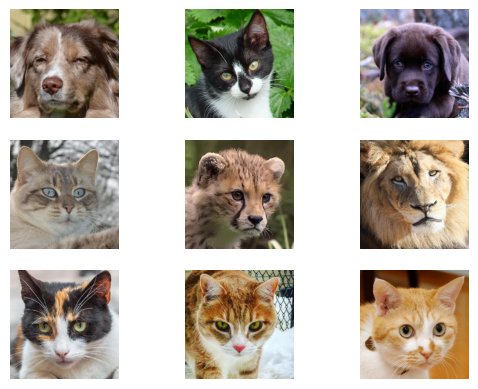

In [92]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

In [185]:
lr = 1e-4
batch_size = 16
EPOCHS = 10

In [96]:
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = True)

In [221]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [223]:
model = Net().to(device)

In [225]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = lr)

In [229]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/10 
    Training Loss: 0.1349 
    Training Accuracy: 93.0741 
    Validation Loss: 0.0244 
    Validation Accuracy: 94.0496
Epoch no. 2/10 
    Training Loss: 0.0905 
    Training Accuracy: 95.4034 
    Validation Loss: 0.019 
    Validation Accuracy: 95.2893
Epoch no. 3/10 
    Training Loss: 0.0619 
    Training Accuracy: 96.9533 
    Validation Loss: 0.018 
    Validation Accuracy: 95.7025
Epoch no. 4/10 
    Training Loss: 0.0474 
    Training Accuracy: 97.6619 
    Validation Loss: 0.0173 
    Validation Accuracy: 96.281
Epoch no. 5/10 
    Training Loss: 0.0342 
    Training Accuracy: 98.3527 
    Validation Loss: 0.0199 
    Validation Accuracy: 95.8264
Epoch no. 6/10 
    Training Loss: 0.0254 
    Training Accuracy: 98.7335 
    Validation Loss: 0.0176 
    Validation Accuracy: 96.0744
Epoch no. 7/10 
    Training Loss: 0.0164 
    Training Accuracy: 99.2472 
    Validation Loss: 0.0233 
    Validation Accuracy: 95.5372
Epoch no. 8/10 
    Training Loss: 0.0152 
 

In [233]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 97.1889 
Loss: 0.0162


## Post-Training Analysis ##

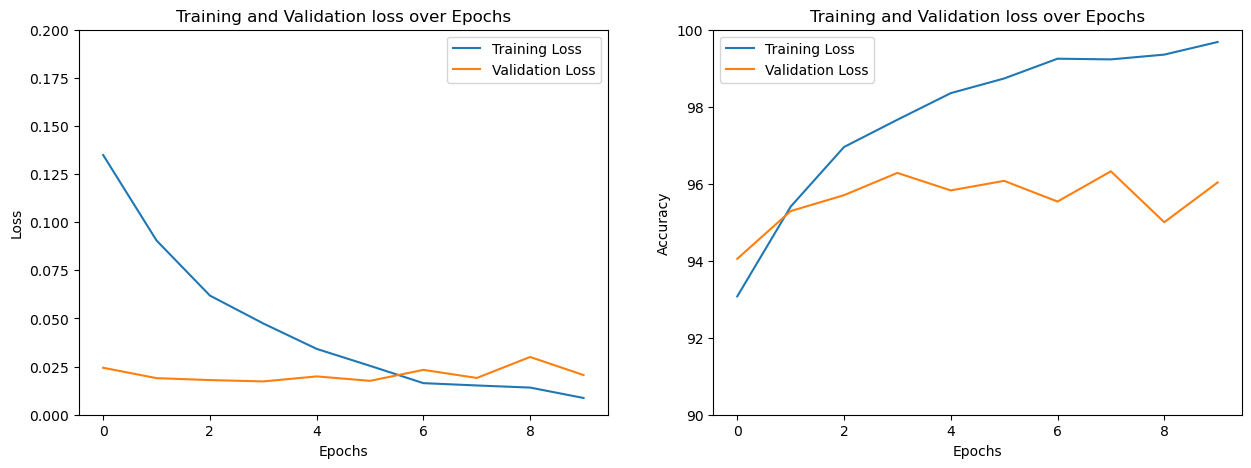

In [245]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([90,100])
axs[1].legend()

plt.show()

In [281]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['wild']


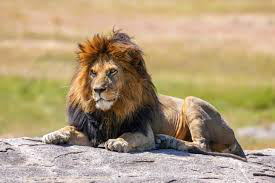

In [301]:
path1 = "/Users/jay/Jupyter Projects/Torch/lion.jpeg"
print(predict_image(path1))
Image.open(path1).convert("RGB")

['dog']


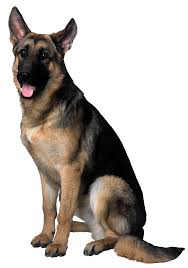

In [299]:
path2 = "/Users/jay/Jupyter Projects/Torch/dawg2.png"
print(predict_image(path2))
Image.open(path2).convert("RGB")